# Verizon

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from aggregators import (
    race, 
    income, 
    redlining, 
    plot_race, 
    bucket_and_bin, 
    speed_breakdown, 
    unserved
)

In [3]:
# input
fn_verizon = '../data/output/speed_price_verizon.csv.gz'

# output
fn_speed = '../data/output/figs/fig1_verizon.csv'

In [4]:
verizon = pd.read_csv(fn_verizon, compression='gzip')
len(verizon)

282622

In [5]:
len(verizon[verizon.speed_down == 0]) / len(verizon)

0.2068947215715691

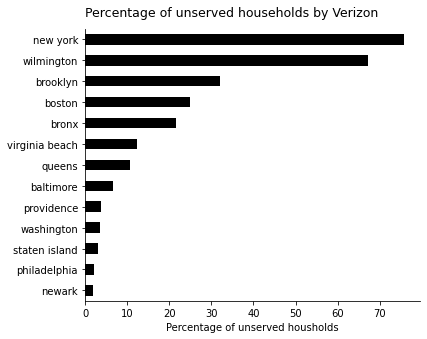

In [6]:
unserved(verizon, isp='Verizon')

In [7]:
verizon.price = verizon.price.replace({40: 39.99, 49.99: 39.99})
verizon = verizon[verizon.price == 39.99]
len(verizon)

224084

In [8]:
nyc_cities = ['new york', 'brooklyn', 'queens', 'staten island', 'brooklyn', 'bronx']

In [9]:
verizon[verizon.major_city.isin(nyc_cities)].major_city.value_counts()

brooklyn         42965
queens           35268
bronx            20495
staten island    10023
new york          5810
Name: major_city, dtype: int64

In [10]:
boro2sample = {
    'new york': 5810,
    'bronx': 5142,
    'brooklyn': 9645,
    'queens': 8599,
    'staten island': 1801
} 

In [11]:
nyc = []
for city, _df in verizon.groupby('major_city'):
    if city in nyc_cities:
        n_sample = boro2sample.get(city)
        nyc.extend(_df.sample(n_sample, random_state=303).to_dict(orient='records'))
#         nyc.extend(_df.to_dict(orient='records'))
nyc = pd.DataFrame(nyc)
nyc['major_city'] = 'new york city'

# add NYC
verizon = verizon[~verizon.major_city.isin(nyc_cities)]
verizon = verizon.append(nyc)

<ipython-input-11-7b9cb340e24e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  verizon = verizon.append(nyc)


In [12]:
len(verizon)

140520

In [13]:
verizon = bucket_and_bin(verizon)

In [14]:
# distribution of speeds
verizon.speed_down.describe()

count    140520.000000
mean        242.252551
std         115.673082
min           1.500000
25%         300.000000
50%         300.000000
75%         300.000000
max         300.000000
Name: speed_down, dtype: float64

In [15]:
# cost per Mbps for packages
40 / verizon.speed_down.describe()

count     0.000285
mean      0.165117
std       0.345802
min      26.666667
25%       0.133333
50%       0.133333
75%       0.133333
max       0.133333
Name: speed_down, dtype: float64

In [16]:
verizon.fastest_speed_down.max()

2048.0

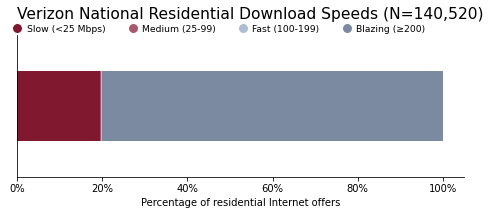

In [17]:
speed_breakdown(verizon, isp='Verizon')

In [18]:
# make the above for each city:
city2speeds = pd.DataFrame()
for (city, state), _df in verizon.groupby(['major_city', 'state']):
    row = _df.speed_down_bins.value_counts(normalize=True, sort=False).to_frame().T
    row.reset_index(drop=True, inplace=True)
    row['major_city'] = city.title()
    row['state'] = state
    city2speeds = pd.concat([city2speeds, row])
city2speeds.to_csv(fn_speed, index=False)

In [19]:
verizon.major_city.nunique()

9

In [20]:
verizon = verizon[verizon.speed_down!=0]

In [21]:
verizon.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)

major_city      state  speed_down_bins
baltimore       MD     Slow (<25 Mbps)    0.990465
                       Blazing (≥200)     0.009535
                       No service         0.000000
                       Medium (25-99)     0.000000
                       Fast (100-199)     0.000000
boston          MA     Blazing (≥200)     0.960885
                       Slow (<25 Mbps)    0.037647
                       Medium (25-99)     0.001468
                       No service         0.000000
                       Fast (100-199)     0.000000
new york city   NY     Blazing (≥200)     0.994322
                       Medium (25-99)     0.004775
                       Slow (<25 Mbps)    0.000774
                       Fast (100-199)     0.000129
                       No service         0.000000
newark          NJ     Blazing (≥200)     0.868137
                       Slow (<25 Mbps)    0.130761
                       Medium (25-99)     0.000882
                       Fast (100-199)     0

In [22]:
variety = verizon.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)
homogenous_cities = list(variety[variety >= .95].index.get_level_values(0))
homogenous_cities.append('wilmington')
len(homogenous_cities)

6

In [23]:
len(verizon[~verizon.major_city.isin(homogenous_cities)])

32886

In [24]:
# who has options?
verizon[(verizon['speed_down'] != verizon['fastest_speed_down']) &
        (~verizon['fastest_speed_down'].isnull())]['speed_down'].value_counts(normalize=True)

300.0    0.999244
200.0    0.000534
15.0     0.000169
100.0    0.000053
Name: speed_down, dtype: float64

In [25]:
# verizon = verizon[~verizon.major_city.isin(homogenous_cities)]
# len(verizon)

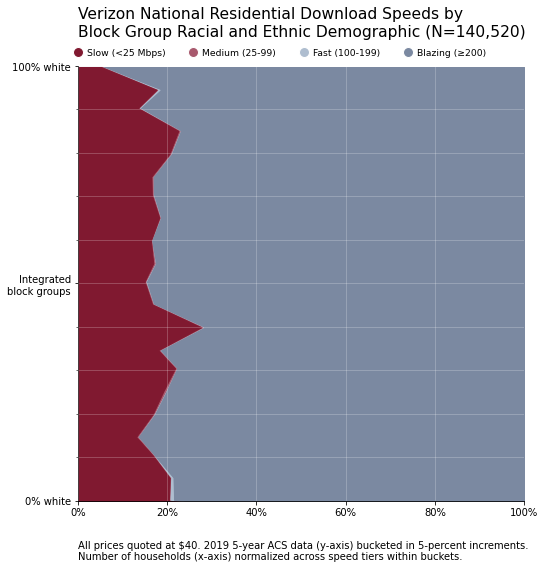

In [26]:
plot_race(verizon, isp='Verizon', price = "$40")

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


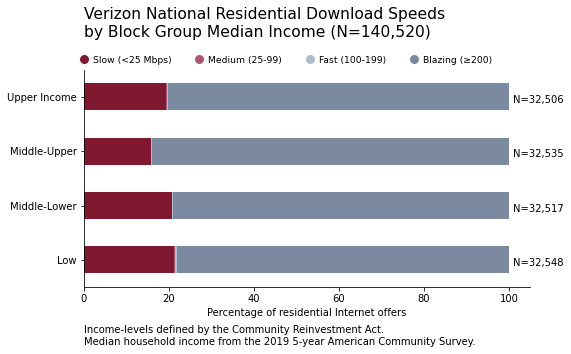

In [27]:
income(verizon, isp='Verizon')

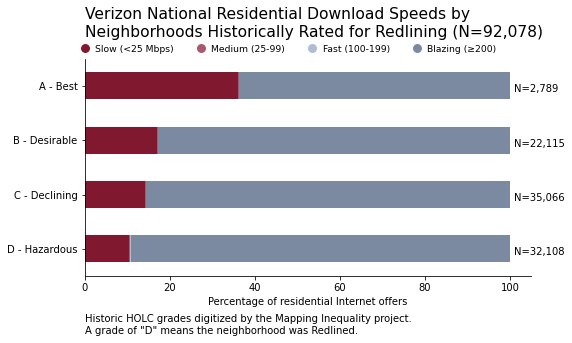

In [28]:
redlining(verizon, isp='Verizon')

## Cities

In [29]:
verizon.major_city.unique()

array(['washington', 'wilmington', 'boston', 'baltimore', 'newark',
       'philadelphia', 'providence', 'virginia beach', 'new york city'],
      dtype=object)

baltimore


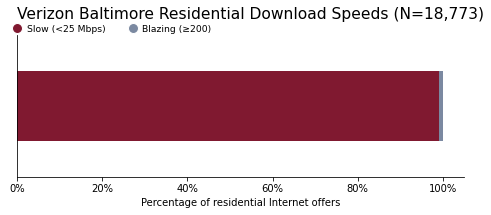

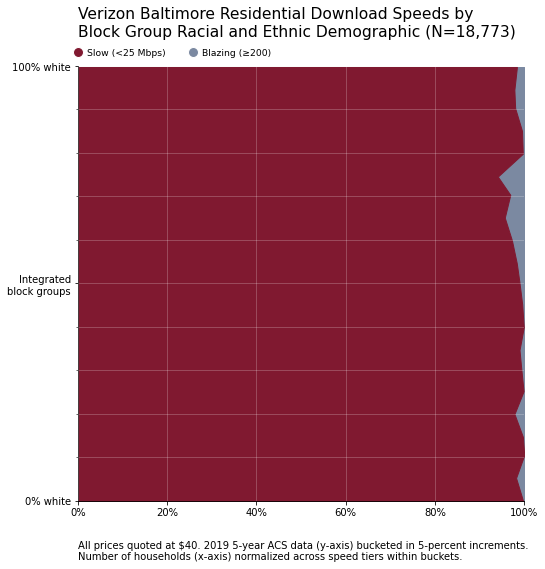

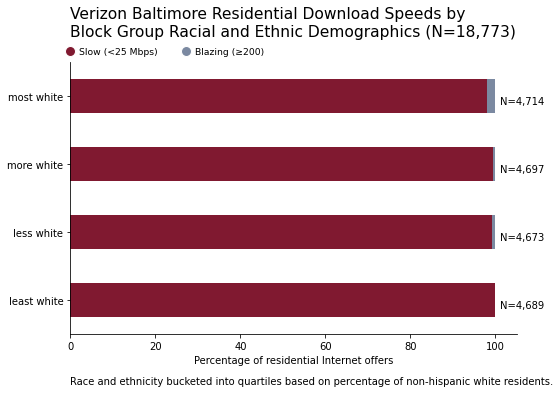

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


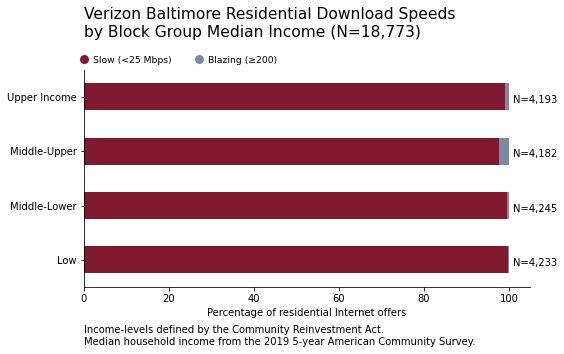

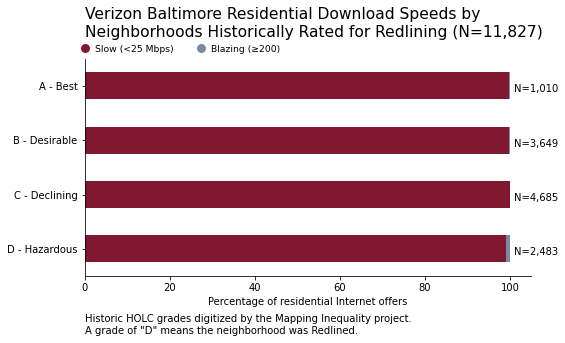

*******************************************************************************
boston


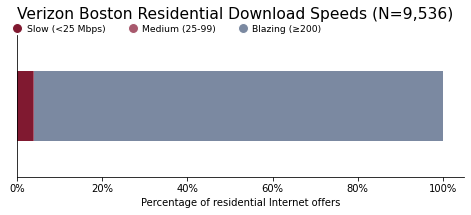

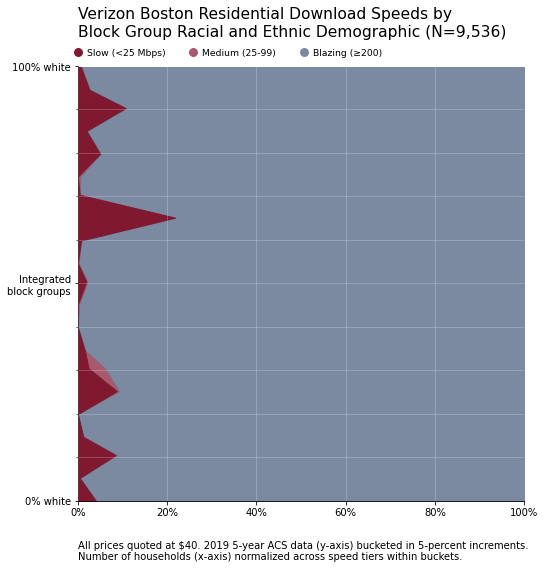

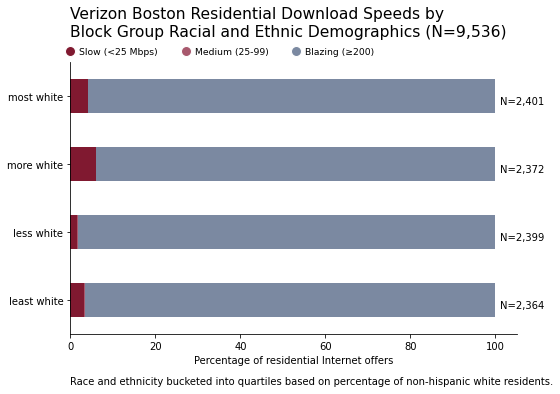

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


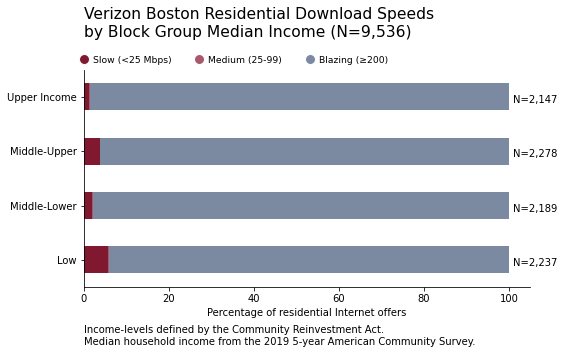

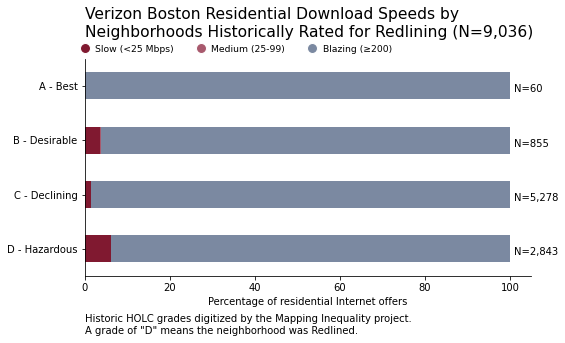

*******************************************************************************
new york city


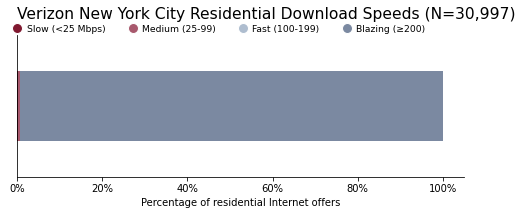

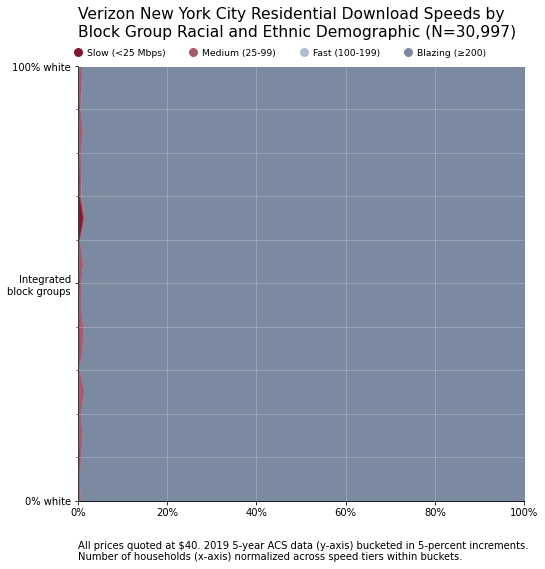

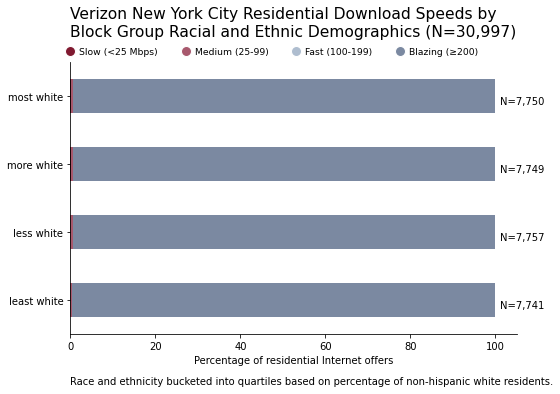

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


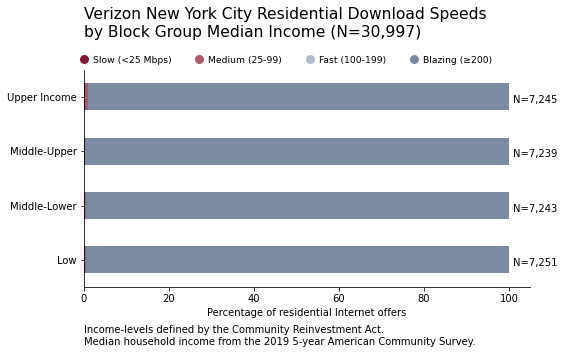

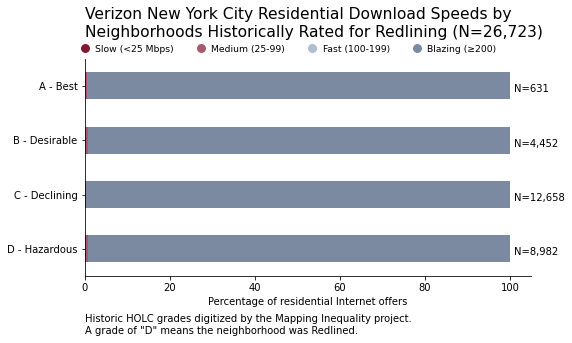

*******************************************************************************
newark


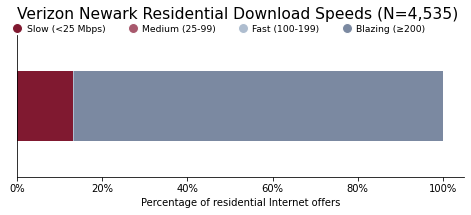

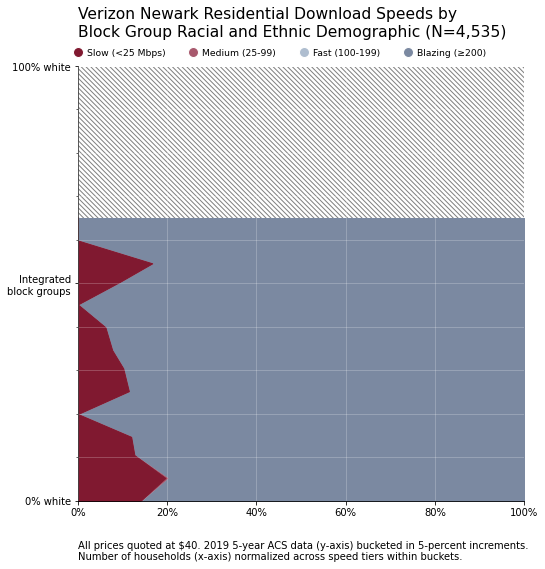

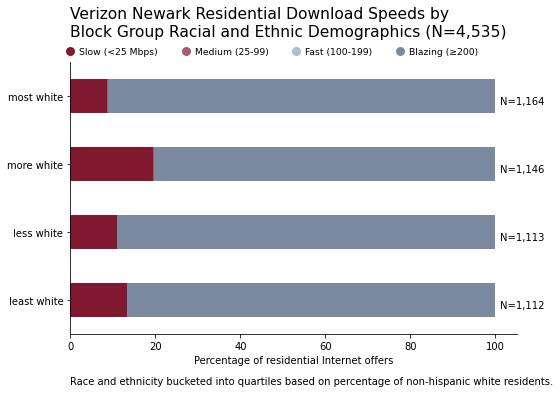

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


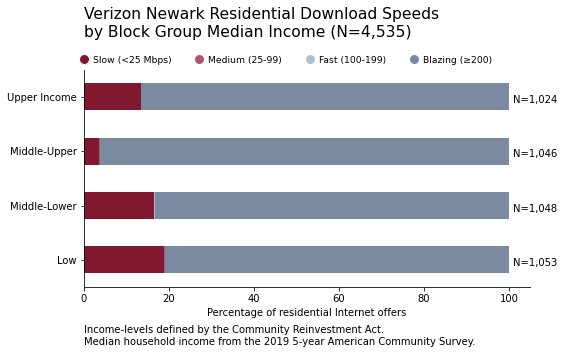

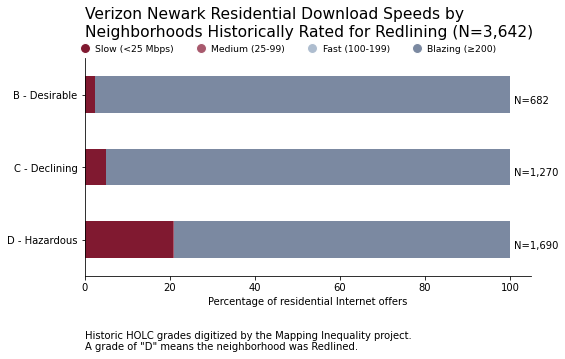

*******************************************************************************
philadelphia


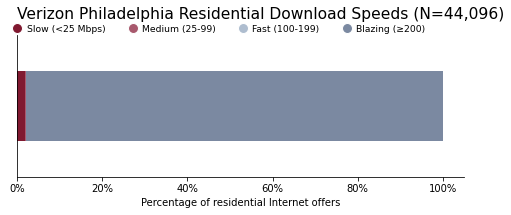

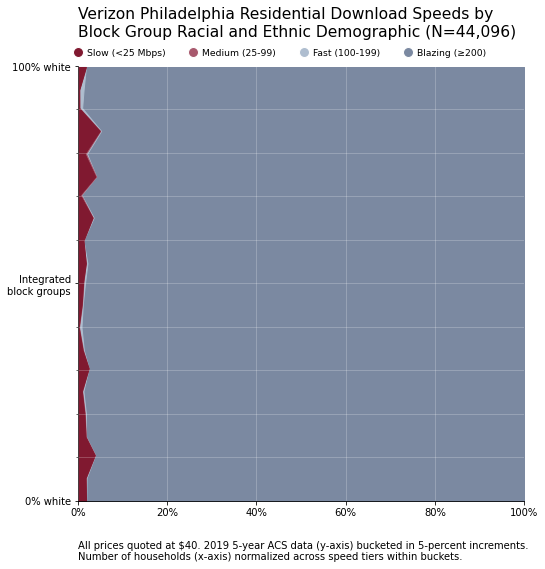

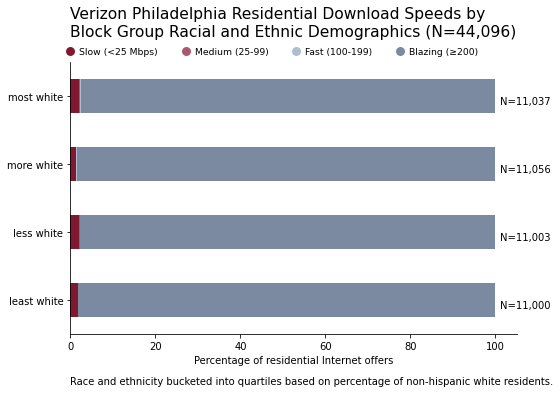

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


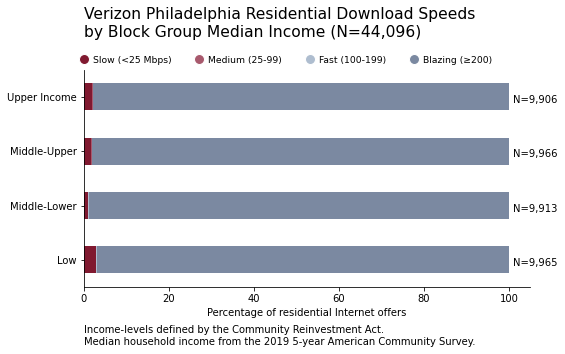

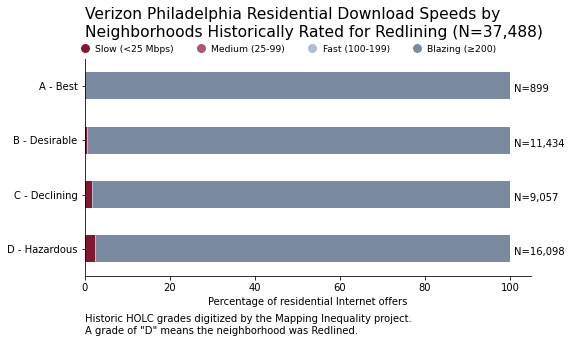

*******************************************************************************
providence


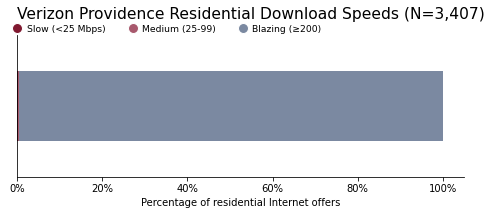

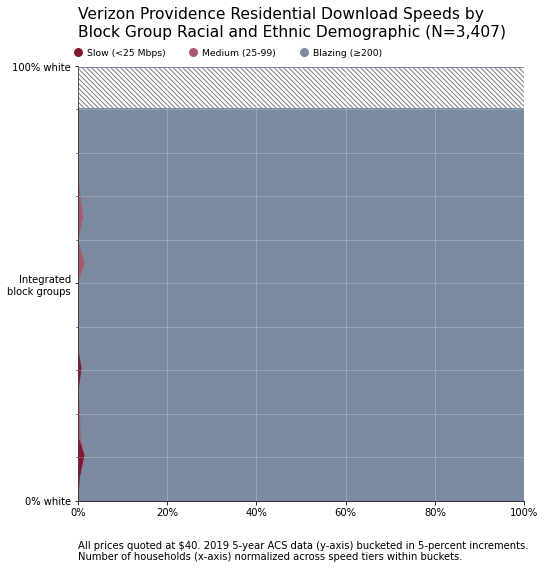

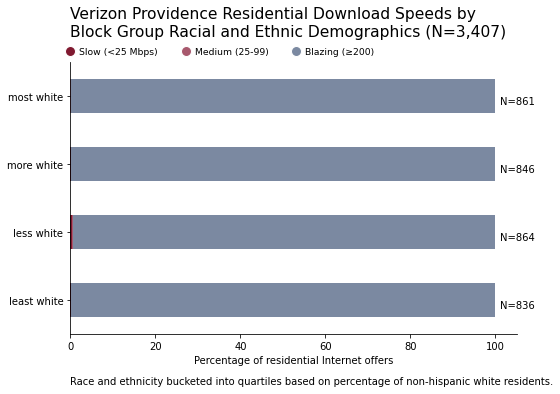

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


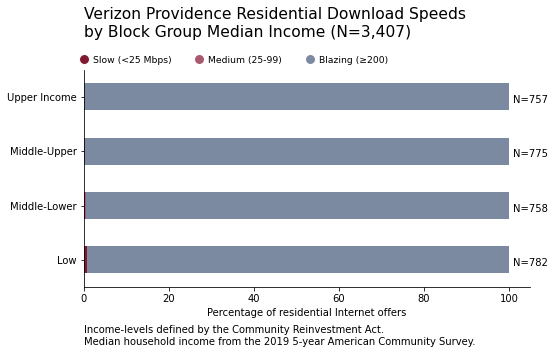

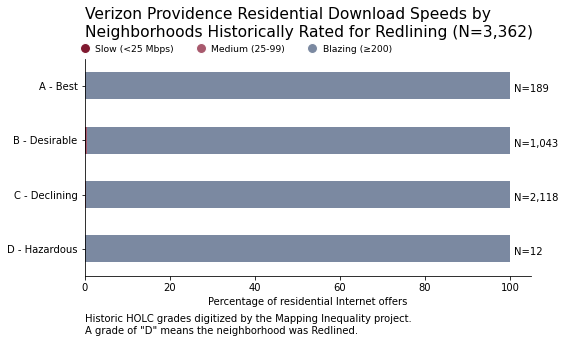

*******************************************************************************
virginia beach


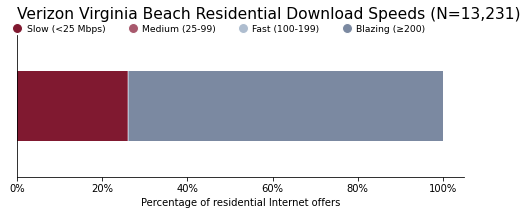

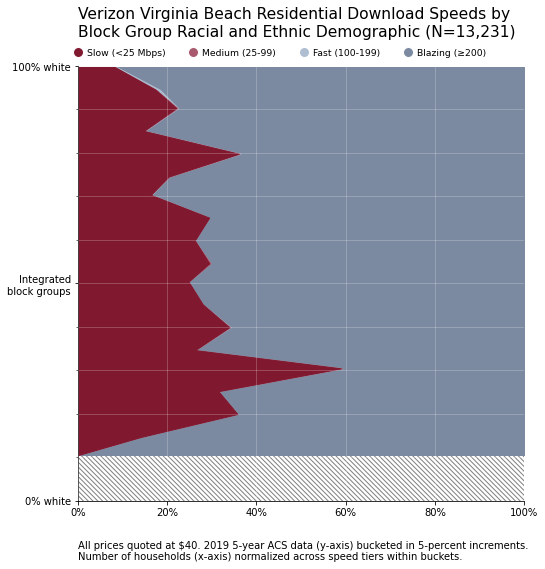

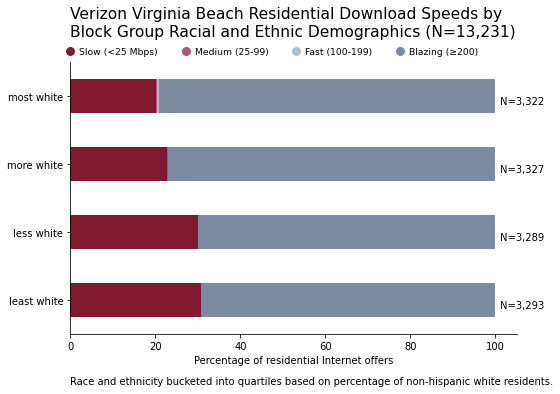

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


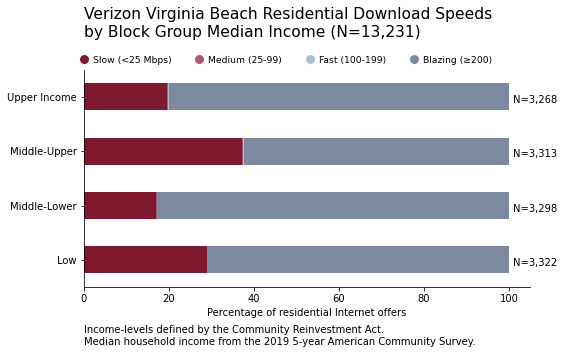

*******************************************************************************
washington


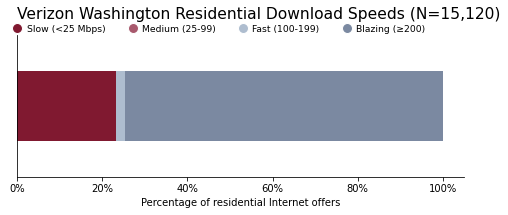

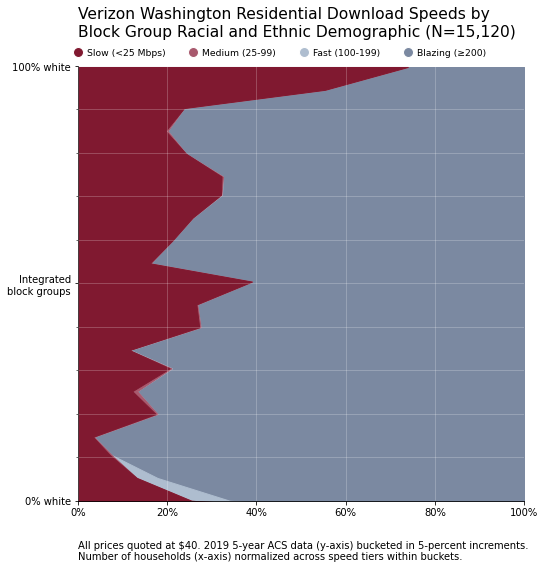

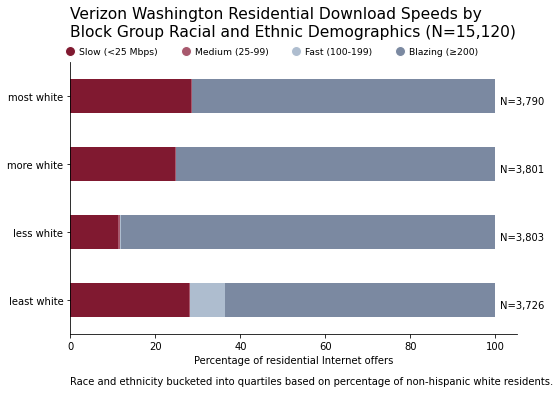

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


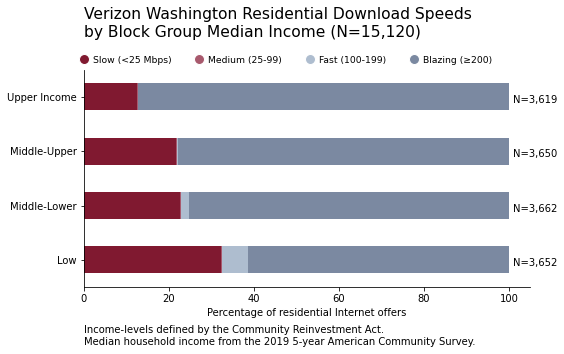

*******************************************************************************
wilmington


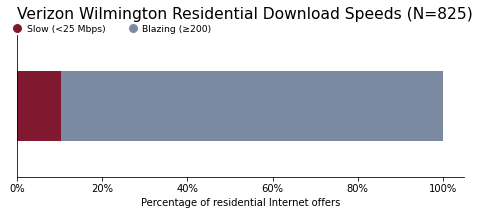

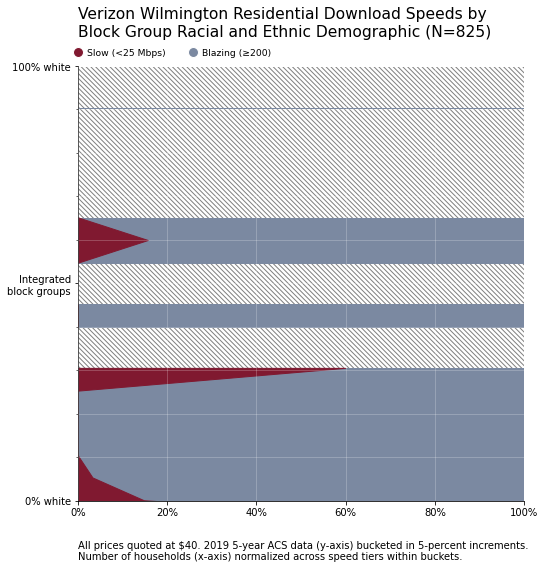

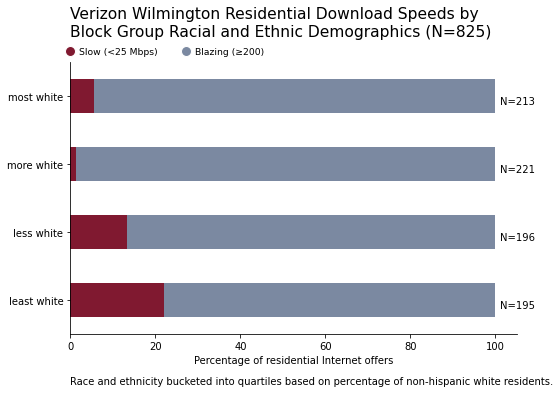

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:247: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'income_level'] = df['income_level'].astype(


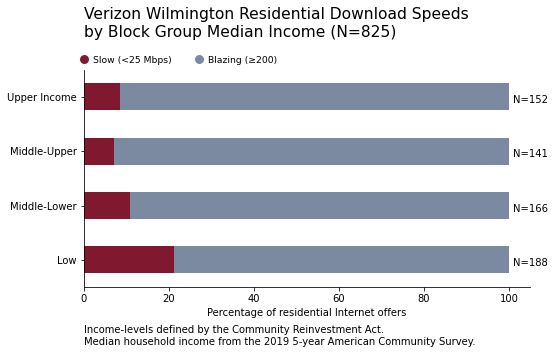

*******************************************************************************


In [30]:
for city, _df in verizon.groupby('major_city'):
    print(city)
    _df = bucket_and_bin(_df)
    speed_breakdown(_df, location=city.title(), isp='Verizon')
    plot_race(_df, location=city.title(), isp='Verizon', price='$40')
    race(_df, location=city.title(), isp='Verizon')
    income(_df, location=city.title(), isp='Verizon')
    redlining(_df, location=city.title(), isp='Verizon')
    print("*" * 79)

In [35]:
verizon.speed_down.min()

1.5

In [36]:
1.5 / 40

0.0375

In [38]:
40 / 1.5

26.666666666666668